In [34]:
from transformers import GPT2Config, GPT2LMHeadModel, GPT2TokenizerFast, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from pathlib import Path
import wandb
import os
import json
import numpy as np
from PIL import Image

In [2]:
wandb.login()

wandb: Currently logged in as: macosta (use `wandb login --relogin` to force relogin)


True

In [35]:
TOKENIZER_SAVEDIR = Path('/home/macosta/ttmp/primus-data/visual-tokens-7/')
LM_MODEL_SAVEDIR = Path('/home/macosta/ttmp/primus-models/gpt2-lm-visual-tokens-7/')
Path(LM_MODEL_SAVEDIR).mkdir(exist_ok=True)
TXT_FILES = Path('/home/macosta/ttmp/primus-data/leipzig-filtered/leipzig-delim-7/')

In [4]:
[torch.cuda.device(i) for i in range(torch.cuda.device_count())]

[<torch.cuda.device at 0x7ff7d3072dd0>, <torch.cuda.device at 0x7ff7d3072f90>]

In [5]:
torch.cuda.set_device(0)
print('Cuda available: ', torch.cuda.is_available())

Cuda available:  True


In [6]:
torch.cuda.current_device()

0

In [36]:
VOCAB_SIZE = 30000
MAX_LEN = 64
tokenizer = GPT2TokenizerFast.from_pretrained(TOKENIZER_SAVEDIR, max_len=MAX_LEN)

file /home/macosta/ttmp/primus-data/visual-tokens-7/config.json not found
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [37]:
list(tokenizer.vocab.items())[0]

('0000000000000000000000000000000000000000000000000011100000000001111111100000000000000011100000000110000011100000000000000011100000000000000000000000000000000000000000000000000_0000000000000000000000000000000000000000000000000011100000000111111111110000000000000011100000000110000011100000000000000011100000000000000000000000000000000000000000000000000_0000000000000000000000000000000000000000000000000011100000001111111111111000000000000011100000000110000011100000000000000011100000000000000000000000000000000000000000000000000_0000000000000000000000000000000000000000000000000011100000011110001111111100000000000011100000001100000011100000000000000011100000000000000000000000000000000000000000000000000_0000000000000000000000000000000000000000000000000011100000111100011111111100000000000011100000001100000011100000000000000011100000000000000000000000000000000000000000000000000_0000000000000000000000000000000000000000000000000011100001111000011111111100000000000011100000011000000011100000000000

In [38]:
tokenizer.unk_token = '<unk>'
tokenizer.bos_token = '<s>'
tokenizer.eos_token = '</s>'
tokenizer.add_special_tokens({'pad_token': '<pad>'})

0

In [39]:
ACTUAL_VOCAB_SIZE = len(tokenizer.vocab)

In [40]:
ACTUAL_VOCAB_SIZE

30001

In [41]:
config = GPT2Config(
    vocab_size=ACTUAL_VOCAB_SIZE,
    n_positions=MAX_LEN,
    n_head=12,
)

model = GPT2LMHeadModel(config=config)
print('Num parameters:', model.num_parameters())

Num parameters: 108145920


In [42]:
class CustomDataset(Dataset):
    def __init__(self, src_files, tokenizer, max_length):
        self.examples = []
        for src_file in tqdm(src_files):
            words = src_file.read_text(encoding="utf-8")
            words = words.split()
            words = ['<s>'] + words + ['</s>']
            for i in range(0, len(words), max_length):
                word_string = ' '.join(words[i:i+max_length])
                tokenized = tokenizer.encode(word_string, max_length=max_length, padding='max_length')
                assert(len(tokenized) == max_length)
                self.examples.append(tokenized)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return torch.tensor(self.examples[i])

In [43]:
def create_train_test_datasets(tokenizer, max_length, fraction=1.0, test_size=0.1):
    src_files = list(Path(TXT_FILES).glob("**/*"))
    src_files = src_files[:int(len(src_files) * fraction)]
    split_index = int(len(src_files) * (1 - test_size))
    train_files = src_files[:split_index]
    test_files = src_files[split_index:]
    train_dataset = CustomDataset(train_files, tokenizer, max_length=max_length)
    test_dataset = CustomDataset(test_files, tokenizer, max_length=max_length)
    return train_dataset, test_dataset

In [44]:
train_dataset, test_dataset = create_train_test_datasets(tokenizer, MAX_LEN, fraction=1, test_size=0.05)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 87.20it/s]


In [45]:
train_dataset.__getitem__(3)

tensor([    0,     5,    88,   925,   449,    64,   767,    67,     4,  2143,
          178, 24970, 28282,  1030,     4,     3,     3,   669,  2972,     3,
        29791,     4,  3293,  5492,     5,     2,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])

In [46]:
def show_whitespaced(txt):
    txt = txt.replace('_', '')
    tokens = txt.split()
    tokens = [t for t in tokens if t[0] != '<']
    txt = ''.join(tokens)
    cols = [txt[i:i+175] for i in range(0, len(txt), 175)]
    arr = [[int(x) for x in col] for col in cols]
    arr = (1 - np.array(arr, dtype=np.uint8)) * 255
    Image.fromarray(arr.T).show()

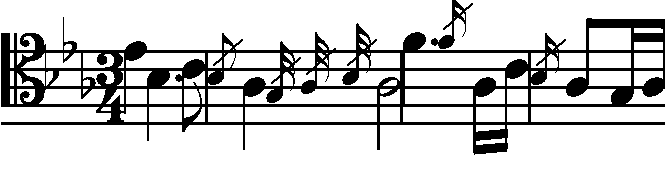

In [49]:
show_whitespaced(tokenizer.decode(train_dataset.__getitem__(3)))

In [50]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [19]:
N_EPOCHS = 15
BATCH_SIZE = 32
N_EVALS = 20

In [15]:
N_STEPS = len(train_dataset) * N_EPOCHS // BATCH_SIZE

In [16]:
STEPS_PER_EVAL = N_STEPS // N_EVALS

In [21]:
training_args = TrainingArguments(
    output_dir=LM_MODEL_SAVEDIR,
    overwrite_output_dir=True,
    num_train_epochs=N_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    logging_steps=STEPS_PER_EVAL,
    evaluation_strategy="steps",
    eval_steps=STEPS_PER_EVAL,
    save_total_limit=1,
    prediction_loss_only=False,
    report_to="wandb",
    save_steps=5000
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

PyTorch: setting up devices


In [22]:
ret = trainer.train()

/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2537
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 800
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/transformers/models/gpt2/modeling_gpt2.py", line 1440, in forward
    return_dict=return_dict,
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/transformers/models/gpt2/modeling_gpt2.py", line 897, in forward
    output_attentions=output_attentions,
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/transformers/models/gpt2/modeling_gpt2.py", line 432, in forward
    feed_forward_hidden_states = self.mlp(hidden_states)
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/transformers/models/gpt2/modeling_gpt2.py", line 360, in forward
    hidden_states = self.act(hidden_states)
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/transformers/activations.py", line 42, in gelu_new
    return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))
RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 23.70 GiB total capacity; 19.31 GiB already allocated; 45.56 MiB free; 19.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


In [ ]:
trainer.save_model(LM_MODEL_SAVEDIR)